In [1]:
import numpy as np
import trimesh
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [2]:
import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Function '{func.__name__}' executed in {end - start:.4f} seconds")
        return result

    return wrapper

In [3]:
mesh = trimesh.load("bracket-1.stl")
mesh.show()

## Trimesh

In [4]:
@timeit
def compute_signed_distance_a(mesh, points):
    """
    Compute the signed distance function for a 3D triangulated mesh
    
    Parameters
    ----------
    mesh (trimesh.Trimesh): 3D mesh
    points (ndarray): Nx3 array of query points

    Returns
    -------
    ndarray: Signed distances for each query point
    """
    return trimesh.proximity.signed_distance(mesh, points)

## Vectorised code

In [5]:
@timeit
def compute_signed_distance_b(mesh, points):
    """
    Compute the signed distance function for a 3D triangulated mesh
    
    Parameters
    ----------
    mesh (trimesh.Trimesh): 3D mesh
    points (ndarray): Nx3 array of query points

    Returns
    -------
    ndarray: Signed distances for each query point
    """
    closest_points, distances, triangle_ids = mesh.nearest.on_surface(points)
    face_normals = mesh.face_normals[triangle_ids]
    displacement = points - closest_points
    sign = np.sign(np.einsum('ij,ij->i', displacement, face_normals))
    sign[sign == 0] = 1
    return sign * distances

## Parallel code

In [6]:
from numba import njit, prange

@njit(parallel=True)
def kernel(points, closest_points, distances, face_normals, triangle_ids):
    """
    Compute signed distances using Numba for performance
    """
    num_points = points.shape[0]
    signed_distances = np.zeros(num_points)

    for i in prange(num_points):
        displacement = points[i] - closest_points[i]
        normal = face_normals[triangle_ids[i]]
        sign = np.sign(np.dot(displacement, normal))
        if sign == 0:
            sign = 1
        signed_distances[i] = sign * distances[i]

    return signed_distances

@timeit
def compute_signed_distance_c(mesh, points):
    """
    Compute the signed distance function for a 3D triangulated mesh
    """
    closest_points, distances, triangle_ids = mesh.nearest.on_surface(points)
    return kernel(points, closest_points, distances, mesh.face_normals, triangle_ids)

## Testing

In [7]:
x = np.linspace(-50, 50, 100)
y = np.linspace(-60, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.full_like(X, fill_value=0.0)

points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])

In [10]:
sdf_values = compute_signed_distance_a(mesh, points)
sdf_values = compute_signed_distance_b(mesh, points)
sdf_values = compute_signed_distance_c(mesh, points)

Function 'compute_signed_distance_a' executed in 3.1065 seconds
Function 'compute_signed_distance_b' executed in 3.0573 seconds
Function 'compute_signed_distance_c' executed in 3.0526 seconds


Text(0, 0.5, 'y')

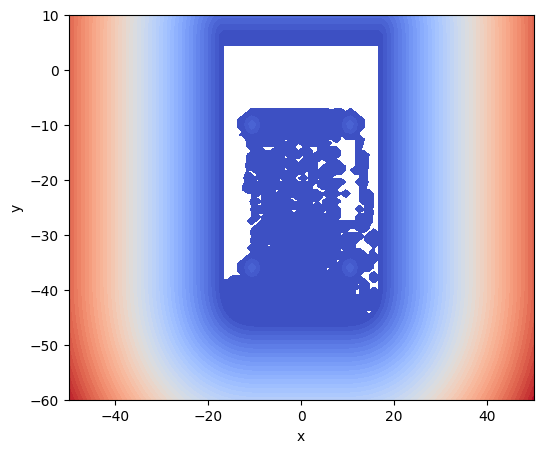

In [11]:
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, sdf_values.reshape(X.shape), levels=50, cmap="coolwarm")
plt.xlabel("x")
plt.ylabel("y")